# Conteo aproximado usando Gibbs Sampler para los modelos hard-core y q-coloring


Autores: 
- Daniel Alejandro García Hernández
- David Camilo Cortes Salazar

En este notebook se encuentra una implementación de algunos resultados vistos en clase para el Gibbs Sampler aplicado a Hard-core y q-colorings. 

Las librerías necesarias para ejectuar el código son:

In [1]:
import random
import numpy as np
import networkx as nx
from copy import deepcopy
import matplotlib.pyplot as plt
from sympy import symbols, simplify

---
# Punto 1 - Valores aproximados a q-coloraciones (q-colorings) usando el teorema 9.1

Iniciamos definiendo algunas funciones que ya habían sido usadas en el programa anterior.


Acto seguido, creamos la grilla del módelo. Para esto, usamos un grafo cuadrado 2D de NetworkX con colores que siguen una diagonal, asegurando así que el estado inicial es una q-coloración válida. 


Este grafo recibe de input las dimensiones $k$ del grafo, y el número $q$ de colores. Se tiene las condiciones:

- $3\leq k \leq 20$,
- $2\leq q \leq 10$.

Los colores ya se encuentran en el código, por lo que no es necesario que el usuario los ingrese.

In [2]:
## Inputs del programa    
"""
k: Dimensiones del lattice kxk
q: Numero de colores
d: Maximo numero de vecinos de algun nodo

Valores posibles:     3>= k >= 20   ->  d = 4    ->     q > 2d = 8

"""

k = 3
q = 4

## Lista de colores preestablecidos. Se usaran los primeros q
colors_list_complete = ["red", "blue", "green", "orange", "grey", "purple", "black", "magenta", "white", "cyan"]

Ahora graficamos el grafo y la q-coloracion inicial

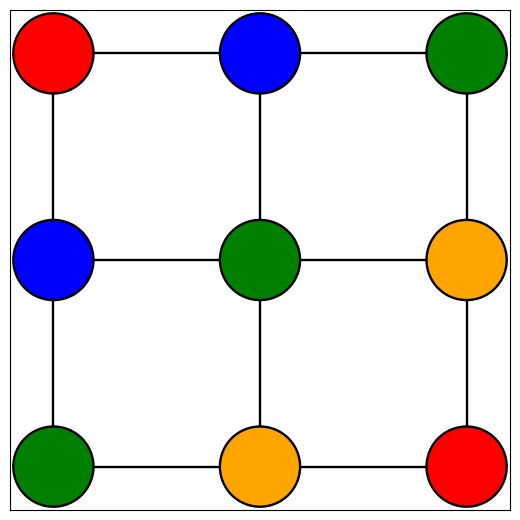

In [3]:
def restart_G(k, q, colors_list):
    """
    Hallar y reiniciar el valor del grafo y el color de los nodos
    :param k: Dimensions of the lattice 
    :param q: Number of colors
    :param colors_list: Listas de colores
    :return: Grafo de networkx con forma de lattice cuadrado y el valor inicial de los colores tal que es q-coloracion
    """
    G = nx.grid_2d_graph(k, k)
    color_values = {node: colors_list[(i + i//k - (i//k)*k)%q] for i, node in enumerate(G.nodes())}
    
    return G, color_values


    
def plot_grid(G, color_values):
    """
    Grafica el grafo, con el color de los nodos dados
    :param G: Grafo de networkx 
    :param color_values: Valor de colores de los nodos del grafo
    :return: 
    """
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    options = {
        "font_size": 200,
        "node_size": int(30000/k**2),
        "edgecolors": "black",
        "linewidths": 1.7,
        "width": 1.7,
        "with_labels": False,
        "node_color": color_values.values(),
    }

    plt.figure(figsize=(5 + 0.1*k, 5 + 0.1*k))
    nx.draw_networkx(G, pos=pos, **options)
    plt.tight_layout()
    plt.show()
    

# Iniciar el valor de los colores
colors_list = colors_list_complete[:q:]
G, color_values = restart_G(k, q, colors_list)


# Graficar la grilla
plot_grid(G, color_values)

Ahora fijamos el numero de simulaciones y pasos del gibbs sampler que vamos a utilizar. Para esto, usaremos el resultado visto en el capitulo 9 del libro para definir una cota superior en estos valores si se cumplen las condiciones necesarias para calcularlos:

- Condiciones: Sean $q$ y $d > 2$ tal que $q > 2d$
- Cota de Simulaciones: $\frac{48d^{3}k^{3}}{\epsilon^{2}}$
- Cota de Pasos (Gibbs Sampler): $k(\frac{2\log{(k)} + \log{(\epsilon^{-1})} + \log(8)}{\log{(\frac{q}{2d})}}+1)$

Note que si, por ejemplom las cota de pasos es $100.000$ y la cota de simulaciones es $100$, el algoritmo tendra que realizar mas de $1.000.000$ pasos. Asi que para fijar los valores de estas variables haremos lo siguiente:

- Si el numero de simulaciones excede los $100.000$, tomaremos solo $500*k*log(k)$.

Por otra parte, si no se cumplen las condiciones necesarias para la definicion de las cotas ($q>2d$), encontraremos que los pasos del Gibbs step daran negativos al usar la formula, por tanto haremos lo siguiente:

- Si el numero de pasos es menor a 0, tomaremos solo $200*k*log(k)$.

In [4]:
def calculate_number_simulations(epsilon, k, q, d=4):
    top = 48 * (d**3) * k**3
    bot = epsilon**2
    return top/bot
    
    
def calculate_number_gibbs_steps(epsilon, k, q, d=4):
    if q==8: return int(200*k*np.log(k))
    top = 2*np.log(k) + np.log(1/epsilon) + np.log(8)
    bot = np.log(q / (2*d))
    ans = k*(top/bot + 1)
    return ans

def steps_validation(steps):
    return int(200*k*np.log(k)) if steps < 0 else int(steps) + 1

def simulations_validation(simulations):
    return int(500*k*np.log(k)) if simulations > 100000 else int(simulations) + 1


In [5]:
epsilon = 0.01

real_gibbs_steps = calculate_number_gibbs_steps(epsilon, k, q)
real_simulations_number = calculate_number_simulations(epsilon, k, q)

print(f"Cota gibbs steps: {real_gibbs_steps}")
print(f"Cota simulaciones: {real_simulations_number}")

gibbs_steps = steps_validation(real_gibbs_steps)
simulations_number = simulations_validation(real_simulations_number)

print(f"Gibss steps tomados: {gibbs_steps}")
print(f"Simulaciones tomadas: {simulations_number}")

Cota gibbs steps: -35.44134357365112
Cota simulaciones: 829440000.0
Gibss steps tomados: 659
Simulaciones tomadas: 1647


### Visualizacion de pasos

Aqui queremos ver que obtenemos $G_{j}$ añadiendo una arista a $G_{j-1}$. Para esto seleccionamos un $j$ arbitrario para visualizar el funcionamiento de la construccion del grafo, miramos el enlace $e_{j}$, y verificamos si los colores son diferentes.

In [6]:
def find_valid_colors(G, color_values, x, y):
    colores_vecinos = set()
    
    for vecino in G.neighbors((x,y)):
        colores_vecinos.add(color_values[vecino])
    
    valid_colors = list(set(colors_list) - colores_vecinos)
    
    return valid_colors    

def systematic_step(G, color_values, x, y):
    valid_colors = find_valid_colors(G, color_values, x, y)
    new_color = random.choice(valid_colors)
    color_values[(x,y)] = new_color
    
    return color_values
    
def find_systematic_evolution(G, color_values, n):
    for ii in range(n): 
        x = ii % k
        y = (ii//k) % k
        color_values = systematic_step(G, color_values, x, y)
        
    return color_values

def random_step(G, color_values):
    x = random.choice(range(0,k))
    y = random.choice(range(0,k))
      
    valid_colors = find_valid_colors(G, color_values, x, y)
    new_color = random.choice(valid_colors)
    color_values[(x,y)] = new_color
    
    return color_values
    
    
def find_random_evolution(G, color_values, n):
    for _ in range(n): 
        color_values = random_step(G, color_values)
        
    return color_values

def find_Gj(G, j):
    edges = list(G.edges)
    edges_to_remove = edges[j+1 : len(edges)]
    Gj = deepcopy(G)
    
    for edge_to_remove in edges_to_remove:
        Gj.remove_edge(edge_to_remove[0], edge_to_remove[1])
        
    return Gj

def find_ej(G, j):
    edges = list(G.edges)
    e_j = edges[j]
    
    return e_j
    

Vértice e_j  que estamos añadiendo: ((1, 0), (1, 1))
Color de los nodos de e_j: blue green
Son diferentes?: True

G_{j-1}:


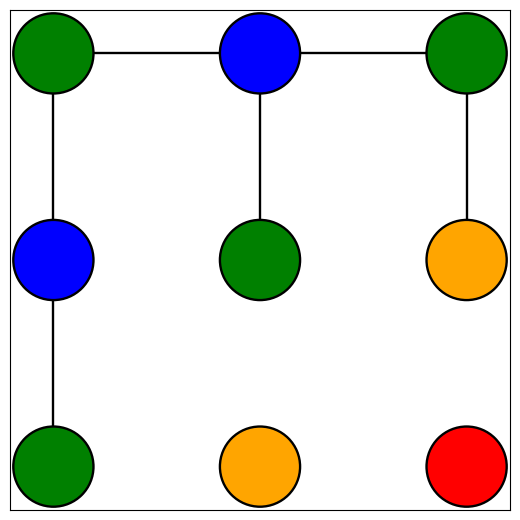




G_{j}:


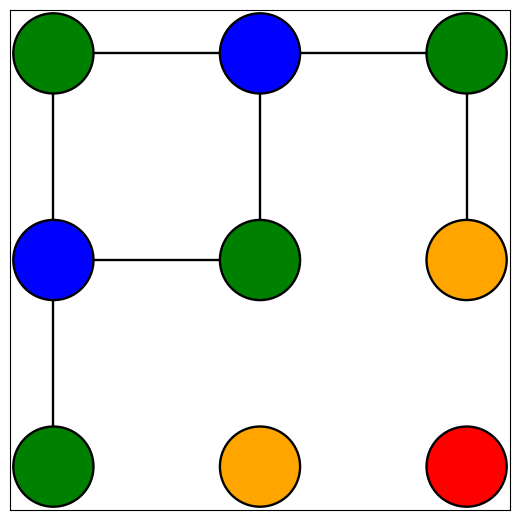

In [7]:
G, color_values = restart_G(k, q, colors_list)

counter_they_are_equal = 0

j = 6

e_j = find_ej(G, j)

G_j_1 = find_Gj(G, j-1)

color_values = find_systematic_evolution(G_j_1, color_values, 1)

print('Vértice e_j  que estamos añadiendo:',  e_j)
print('Color de los nodos de e_j:', color_values[e_j[0]], color_values[e_j[1]])
print(f'Son diferentes?: {color_values[e_j[0]] != color_values[e_j[1]]}')


print("\nG_{j-1}:")
plot_grid(G_j_1, color_values)


## Verificacion. Grafica de G_j. Sirve para comparar con G_j_1 y ver el indice e_j
G_j = deepcopy(G_j_1)
G_j.add_edge(e_j[0], e_j[1])
print("\n\n\nG_{j}:")
plot_grid(G_j, color_values)

### Algoritmo

Nuestro objetivo es calcular el numero de q-coloraciones $Z_{\hat{k}}$ como una relacion de cocientes. Para esto, calcualmos $Z_{\hat{k}}$ apartir de la relacion telescopica:

- $Z_{\hat{k}} = Z_{0}\prod_{j=1}^{\hat{k}}\frac{Z_{j}}{z_{j-1}}$

Donde $Z_{0}$ es el numero de q-coloraciones posibles sin restriccion y $\frac{Z_{j}}{z_{j-1}}$ es la probabilidad de que una coloracion de $G_{j-1}$ tambien sea valida para $G_{j}$.

Para esto debemos estimar cada cociente $\frac{Z_{j}}{z_{j-1}}$. Esto lo hacemos iterando el siguiente paso:

- Para cada nueva arista añadida en el grafo, ejecutamos el Gibbs sampler para generar múltiples q-coloraciones válidas del grafo anterior $G_{j-1}$
- Tomamos $\frac{Z_{j}}{z_{j-1}}$ como la proporcion de coloraciones validas para $G_{j-1}$ que siguen siendo validas para $G_{j}$. Es decir, sea $N$ el numero de coloraciones validas generadas para $G_{j-1}$ y $M$ El numero de coloraciones que siguen siendo validas en $G_{j}$, entonces $\frac{Z_{j}}{z_{j-1}} \approx \frac{M}{N}$.


Y al final tenemos un conteo aproximado de q-coloraciones para el lattice de las dimensiones escogidas.

In [8]:
n_simulations = simulations_validation(calculate_number_simulations(epsilon, k, q))
n_gibbs_steps = steps_validation(calculate_number_gibbs_steps(epsilon, k, q))

q_colorings = q**(k*k)

G, color_values = restart_G(k, q, colors_list)    

for j in range(1, len(list(G.edges()))):
    rho_j_1 = 0
    e_j = find_ej(G, j) # Edge which is in G_{j} but not in G_{j−1}
        
    for ii in range (n_simulations):
        G, color_values = restart_G(k, q, colors_list)    

        G_j_1 = find_Gj(G, j-1)
            
        color_values = find_systematic_evolution(G_j_1, color_values, n_gibbs_steps)
    
        rho_j_1 += int(color_values[e_j[0]] != color_values[e_j[1]])
    
    rho_j_1 = rho_j_1 / n_simulations
    q_colorings *= rho_j_1

print(f"Condiciones: k={k}, q={q}")
print(f"Conteo Aproximado: {int(q_colorings)}")

Condiciones: k=3, q=4
Conteo Aproximado: 12835


Ahora, insertamos todo en una funcion para facilidad en el reporte.

In [9]:
def estimate_q_colorings(k, q, epsilon, colors_list=None):    
    if colors_list is None:
        colors_list = ["red", "blue", "green", "orange", "grey", "purple", "black", "magenta", "white", "cyan"]
        
    n_simulations = simulations_validation(calculate_number_simulations(epsilon, k, q))
    n_gibbs_steps = steps_validation(calculate_number_gibbs_steps(epsilon, k, q))
    
    q_colorings = q**(k*k)

    G, color_values = restart_G(k, q, colors_list)    
    for j in range(1, len(list(G.edges()))):
        rho_j_1 = 0
        e_j = find_ej(G, j) # Edge which is in G_{j} but not in G_{j−1}
            
        for ii in range (n_simulations):
            G, color_values = restart_G(k, q, colors_list)    
            G_j_1 = find_Gj(G, j-1)
            color_values = find_systematic_evolution(G_j_1, color_values, n_gibbs_steps)
            rho_j_1 += int(color_values[e_j[0]] != color_values[e_j[1]])
        
        rho_j_1 = rho_j_1 / n_simulations
        q_colorings *= rho_j_1
    
    return q_colorings


def estimate_q_colorings_multiple_runs(k, q, epsilon, num_runs):
    q_colorings = []
    
    for _ in range(num_runs):
        new_value = estimate_q_colorings(k, q, epsilon)
        q_colorings.append(new_value)
    
    avg = np.average(q_colorings)
    std = np.std(q_colorings)
    
    return avg, std



def theoretical_q_colorings(k, q, q_colorings):
    G, color_values = restart_G(k, q, colors_list_complete[:q:])
    chromatic_poly = nx.chromatic_polynomial(G)
    x = symbols('x')
    exact = chromatic_poly.subs(x, q)
    error_perc = abs(q_colorings - exact)*100/exact

    return exact, error_perc



def print_q_colorings(k, q, epsilon, avg, std, exact_q_colorings, error_percentage):
    print(f'k Dimension del lattice: {k}')
    print(f'q Numero de colores: {q}')
    print(f'epsilon de la funcion: {epsilon}')
    print(f'Numero de simulaciones: {simulations_validation(calculate_number_simulations(epsilon, k, q))}')
    print(f'Numero de pasos de Gibbs sampler: {steps_validation(calculate_number_gibbs_steps(epsilon, k, q))}')
    print(f'Numero de q-coloraciones experimental: {avg:.1f}', u"\u00B1", f'{std:.1f}')
    print(f"Numero de q-coloraciones teórico: {exact_q_colorings}")
    print(f"Porcentaje de error: {error_percentage:.2f} %")
    print("=====================================")
    print()

## Reporte Q-Coloraciones

Veamos como se comporta el conteo aproximado dando diferentes valores de epsilon sobre el mismo grafo, con varios números de colores: 4, 8, 12. El numero de pasos de las simulaciones y del gibbs sampler se toman de la misma forma que explicamos anteriormente.

In [16]:
errors_values = []
q_coloring_values = []
q_coloring_uncert = []

epsilon_values = [0.001, 0.01, 0.1]

def report_run(k, q, num_runs):
    errors = []
    q_colorings_array = []
    q_colorings_uncert_array = []
    
    for epsilon in epsilon_values:
        avg, std = estimate_q_colorings_multiple_runs(k, q, epsilon, num_runs)
        exact, errors_perc = theoretical_q_colorings(k, q, avg)
        print_q_colorings(k, q, epsilon, avg, std, exact, errors_perc)
        errors.append(errors_perc)
        q_colorings_array.append(avg)
        q_colorings_uncert_array.append(std)
        
    errors_values.append(errors)
    q_coloring_values.append(q_colorings_array)
    q_coloring_uncert.append(q_colorings_uncert_array)
    

report_run(k = 3, q = 4, num_runs = 2)
report_run(k = 3, q = 8, num_runs = 2)
report_run(k = 3, q = 12, num_runs = 2)

k Dimension del lattice: 3
q Numero de colores: 4
epsilon de la funcion: 0.001
Numero de simulaciones: 1647
Numero de pasos de Gibbs sampler: 659
Numero de q-coloraciones experimental: 13362.1 ± 297.0
Numero de q-coloraciones teórico: 9612
Porcentaje de error: 39.01 %

k Dimension del lattice: 3
q Numero de colores: 4
epsilon de la funcion: 0.01
Numero de simulaciones: 1647
Numero de pasos de Gibbs sampler: 659
Numero de q-coloraciones experimental: 12361.5 ± 157.3
Numero de q-coloraciones teórico: 9612
Porcentaje de error: 28.60 %

k Dimension del lattice: 3
q Numero de colores: 4
epsilon de la funcion: 0.1
Numero de simulaciones: 1647
Numero de pasos de Gibbs sampler: 659
Numero de q-coloraciones experimental: 12143.4 ± 483.0
Numero de q-coloraciones teórico: 9612
Porcentaje de error: 26.34 %

k Dimension del lattice: 3
q Numero de colores: 8
epsilon de la funcion: 0.001
Numero de simulaciones: 1647
Numero de pasos de Gibbs sampler: 660
Numero de q-coloraciones experimental: 6277638.

Visualicemos el redimiento de estos epsilon, tanto en el numero estimado de q-coloraciones como en el porcentaje de error que tiene esta estimación respecto al valor teórico, encontrado con el polinomio cromático

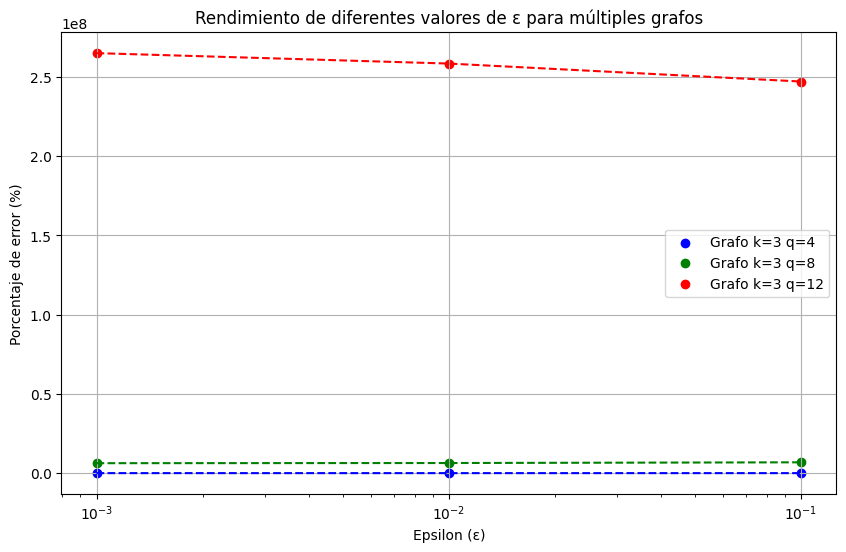

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(epsilon_values, q_coloring_values[0], color='blue', label='Grafo k=3 q=4')
plt.scatter(epsilon_values, q_coloring_values[1], color='green', label='Grafo k=3 q=8')
plt.scatter(epsilon_values, q_coloring_values[2], color='red', label='Grafo k=3 q=12')

plt.plot(epsilon_values, q_coloring_values[0], color='blue', linestyle='--')
plt.plot(epsilon_values, q_coloring_values[1], color='green', linestyle='--')
plt.plot(epsilon_values, q_coloring_values[2], color='red', linestyle='--')

plt.xlabel('Epsilon (ε)')
plt.ylabel('Porcentaje de error (%)')
plt.title('Rendimiento de diferentes valores de ε para múltiples grafos')

plt.legend()
plt.xscale("log")
plt.grid(True)

plt.show()

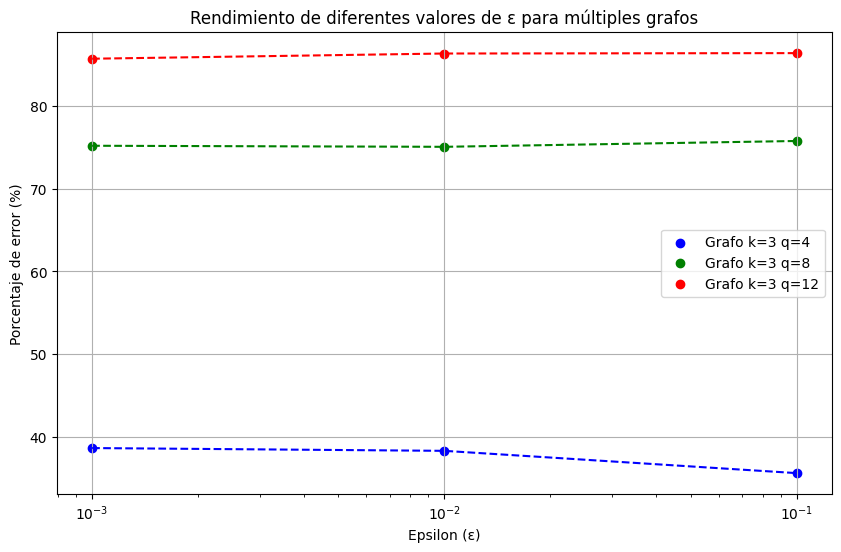

In [34]:
plt.figure(figsize=(10, 6))

plt.scatter(epsilon_values, errors_values[0], color='blue', label='Grafo k=3 q=4')
plt.scatter(epsilon_values, errors_values[1], color='green', label='Grafo k=3 q=8')
plt.scatter(epsilon_values, errors_values[2], color='red', label='Grafo k=3 q=12')

plt.plot(epsilon_values, errors_values[0], color='blue', linestyle='--')
plt.plot(epsilon_values, errors_values[1], color='green', linestyle='--')
plt.plot(epsilon_values, errors_values[2], color='red', linestyle='--')

plt.xlabel('Epsilon (ε)')
plt.ylabel('Porcentaje de error (%)')
plt.title('Rendimiento de diferentes valores de ε para múltiples grafos')

plt.legend()
plt.xscale("log")
plt.grid(True)

plt.show()

---
# Punto 2 - Valores aproximados de configuraciones factibles para el modelo Hard-Core

Teniendo ya la implementacion anterior para un conteo aproximado de configuraciones factibles, basta repmplazar la logica en que se contruye el grafo (elimiar las coloraciones) y cammbiar el gibbs samples para configuraciones factibles de este modelo.

In [14]:
def restart_G_hard_core(k):
    # Create a lattice, kxk graph
    G = nx.grid_2d_graph(k, k)

    # Define the positions for plotting
    pos = {(x, y): (y, -x) for x, y in G.nodes()}
    
    # Color of the nodes
    color_values = {node: "white" for i, node in enumerate(G.nodes())}
    return G, color_values

def hard_core_step(G, color_values, x, y):

    coin = random.choice(("cara", "sello"))

    if coin == "cara":
        
        if "black" in [color_values[vecino] for vecino in [n for n in G.neighbors((x,y))]]: # Revisa si algun vecino es negro
            color_values[(x,y)] = "white" # Si es cierto, el nodo se cambia a blanco
        else: color_values[(x,y)] = "black" # Si es falso, el nodo se cambia a negro

    else:
        color_values[(x,y)] = "white"

    return color_values

def find_hard_core_evolution(G, k, color_values, n):
    for ii in range(n): 
        x = random.choice(range(0,k))
        y = random.choice(range(0,k))
        color_values = hard_core_step(G, color_values, x, y)
        
    return color_values

### Algoritmo

Este funciona con la misma idea de el mencionado para el punto anterior, la diferncia es la implementacion del gibss sampler al modelo hard-core

In [28]:
n_simulations = 100
n_gibbs_steps = 1000

G, color_values = restart_G_hard_core(k)    

k = 3
factibles = 2**(k*k)

for j in range(1, len(list(G.edges()))):
    rho_j_1 = 0
    e_j = find_ej(G, j) # Edge which is in G_{j} but not in G_{j−1}
        
    for ii in range (n_simulations):
        G, color_values = restart_G_hard_core(k)    

        G_j_1 = find_Gj(G, j-1)
            
        color_values = find_hard_core_evolution(G_j_1, k, color_values, n_gibbs_steps)
    
        rho_j_1 += int(not (color_values[e_j[0]] == "black" and color_values[e_j[1]] == "black"))
    
    rho_j_1 = rho_j_1 / n_simulations
    factibles *= rho_j_1

print(f"Conteo Aproximado: {int(factibles)}")

Conteo Aproximado: 80


Ahora, insertamos todo en una funcion para facilidad en el reporte.

In [34]:
def estimate_hard_core(k, simul, gstep):    
        
    n_simulations = simul
    n_gibbs_steps = gstep
    
    factibles = 2**(k*k)

    G, color_values = restart_G_hard_core(k)    
    for j in range(1, len(list(G.edges()))):
        rho_j_1 = 0
        e_j = find_ej(G, j) # Edge which is in G_{j} but not in G_{j−1}
            
        for ii in range (n_simulations):
            G, color_values = restart_G_hard_core(k)    

            G_j_1 = find_Gj(G, j-1)
                
            color_values = find_hard_core_evolution(G_j_1, k, color_values, n_gibbs_steps)
        
            rho_j_1 += int(not (color_values[e_j[0]] == "black" and color_values[e_j[1]] == "black"))
        
        rho_j_1 = rho_j_1 / n_simulations
        factibles *= rho_j_1
    
    return factibles


def estimate_hard_core_multiple_runs(k, simul, gstep, num_runs):
    factibles = []
    
    for _ in range(num_runs):
        new_value = estimate_hard_core(k, simul, gstep)
        factibles.append(new_value)
    
    avg = np.average(factibles)
    std = np.std(factibles)
    
    return avg, std

def print_hard_core(k, avg, std, simul, gstep):
    print(f'k Dimension del lattice: {k}')
    print(f'Numero de simulaciones: {simul}')
    print(f'Numero de pasos de Gibbs sampler: {gstep}')
    print(f'Numero de configuraciones factibles : {avg:.1f}', u"\u00B1", f'{std:.1f}')
    print("=====================================")
    print()

## Reporte Hard-Core

Veamos como se comporta el conteo aproximado dando diferentes valores para los pasos del gibbs sampler y las simulaciones.

In [35]:
simulations_arr = [1, 10, 100]
gibbs_steps_arr = [100, 1000, 10000]

errors_values = []

def report_run(k, num_runs):
    for simul in simulations_arr:
        error = []
        for gstep in gibbs_steps_arr:
            avg, std = estimate_hard_core_multiple_runs(k, simul, gstep, num_runs)
            print_hard_core(k, avg, std, simul, gstep)
            error.append(std)
        errors_values.append(error)

report_run(k = 3, num_runs = 2)


[0.0, 0.0]
k Dimension del lattice: 3
Numero de simulaciones: 1
Numero de pasos de Gibbs sampler: 100
Numero de configuraciones factibles : 0.0 ± 0.0
[0.0, 0.0]
k Dimension del lattice: 3
Numero de simulaciones: 1
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 0.0 ± 0.0
[512.0, 0.0]
k Dimension del lattice: 3
Numero de simulaciones: 1
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 256.0 ± 256.0
[89.18138880000002, 45.14807808000001]
k Dimension del lattice: 3
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 100
Numero de configuraciones factibles : 67.2 ± 22.0
[48.759924326400004, 71.34511104000002]
k Dimension del lattice: 3
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 60.1 ± 11.3
[76.18738176, 62.42697216000001]
k Dimension del lattice: 3
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 69.3 ± 6.9
[

Visualicemos como se comporta el error en relacion al numero de pasos del gibss sampler con las simulaciones

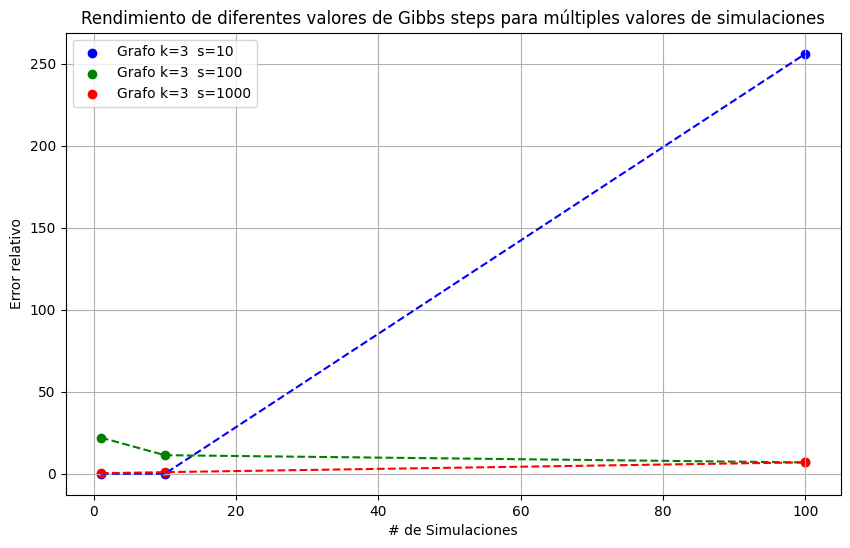

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(simulations_arr, errors_values[0], color='blue', label='Grafo k=3  s=10')
plt.scatter(simulations_arr, errors_values[1], color='green', label='Grafo k=3  s=100')
plt.scatter(simulations_arr, errors_values[2], color='red', label='Grafo k=3  s=1000')

plt.plot(simulations_arr, errors_values[0], color='blue', linestyle='--')
plt.plot(simulations_arr, errors_values[1], color='green', linestyle='--')
plt.plot(simulations_arr, errors_values[2], color='red', linestyle='--')

plt.xlabel('# de Simulaciones')
plt.ylabel('Error relativo')
plt.title('Rendimiento de diferentes valores de Gibbs steps para múltiples valores de simulaciones')

plt.legend()


plt.grid(True)

plt.show()

In [ ]:
chromatic_poly = nx.chromatic_polynomial(G)
print(chromatic_poly)

x = symbols('x')
result = chromatic_poly.subs(x, q)
error_perc = abs(q_colorings - result)*100/result
print(f"El numero teorico de q-coloraciones es {result}. Porcentaje de error: {error_perc:.2f} %")

